Connected to GenAMM (Python 3.11.4)

In [2]:
import pickle
import qGaussian
import qPowerLaw
import qlogNormal
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from datetime import datetime
from scipy.stats import kstest
import matplotlib.pyplot as plt
from tradingstrategy.client import Client
from tradingstrategy.timebucket import TimeBucket
sns.set_theme()

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

dataset_path = '../data/usdc_weth_005.pickle'
with open(dataset_path, 'rb') as f:
    df = pickle.load(f)
df.index = pd.to_datetime(df.index)

df = df[ (df.index >= datetime(2023, 1, 1, 0, 0, 0)) & (df.index < datetime(2024, 1, 1, 0, 0, 0)) ]
df_swap = df[ (df.Event=='Swap_X2Y') | (df.Event=='Swap_Y2X') ]
df_mint = df[ df.Event=='Mint' ]
df_burn_mint = df[ (df.Event=='Burn') | (df.Event=='Mint') ]
df_burn = df[ df.Event=='Burn' ]

'''
df_burn_mint_full = df_burn_mint.copy()
df_burn_mint = df_burn_mint[['block_number', 'Event', 'tick_lower', 'tick_upper', 'amount0', 'amount1', 'amount']]
df_swap_full = df_swap.copy()
df_swap = df_swap[['block_number', 'Event', 'tick', 'liquidity', 'amount0', 'amount1', 'amount']]
'''

"\ndf_burn_mint_full = df_burn_mint.copy()\ndf_burn_mint = df_burn_mint[['block_number', 'Event', 'tick_lower', 'tick_upper', 'amount0', 'amount1', 'amount']]\ndf_swap_full = df_swap.copy()\ndf_swap = df_swap[['block_number', 'Event', 'tick', 'liquidity', 'amount0', 'amount1', 'amount']]\n"

In [3]:
with open('../data/burn_lo.pickle', 'rb') as f:
    burn_lo = pickle.load(f)

print('There are', 100*burn_lo.tick_end.isna().sum()/len(burn_lo),
    '% NaN')
burn_lo = burn_lo.dropna()
burn_lo[[
    'tick_lower', 'tick_upper', 'block_start',
    'tick_start', 'block_end', 'tick_end'
    ]] =burn_lo[[
        'tick_lower', 'tick_upper', 'block_start',
        'tick_start', 'block_end', 'tick_end']].astype(int)


There are 0.0 % NaN


In [4]:
from scipy.stats import skewtest
print('The skew test (H0: skew=Normal skew) result is:',
      skewtest((burn_lo.tick_lower - burn_lo.tick_start).values))

The skew test (H0: skew=Normal skew) result is: SkewtestResult(statistic=-279.77850054454575, pvalue=0.0)


In [8]:
# Start tick in the range
print('There are', 100*len(burn_lo[(burn_lo.tick_start > burn_lo.tick_lower) &\
    (burn_lo.tick_start < burn_lo.tick_upper)]) / len(burn_lo),
    '% values with tick_start in range=]tick_lower, tick_upper[')

# Right side: tick_start <= tick_lower => Buy WETH
print('There are', 100*len(burn_lo[
    burn_lo.tick_start <= burn_lo.tick_lower]) / len(burn_lo),
    '% values with tick_start <= tick_lower')

# Left side: tick_start >= tick_upper => Sell WETH
print('There are', 100*len(burn_lo[
    burn_lo.tick_start >= burn_lo.tick_lower+10]) / len(burn_lo),
    '% values with tick_start >= tick_upper')

There are 77.81350482315112 % values with tick_start in range=]tick_lower, tick_upper[
There are 17.173341128325053 % values with tick_start <= tick_lower
There are 5.013154048523823 % values with tick_start >= tick_upper


In [9]:
def discrete_fit(x_train, distr, init_pars, bounds):
    from scipy.optimize import minimize
    from scipy.optimize import Bounds
    # Define the negative log-likelihood function
    def neg_ll(pars, data, distr):
        # PMF for given lambda_param
        pmf_values = distr.pmf(data, *pars)
        # Avoid log(0) by replacing very small pmf values with a small number
        pmf_values = np.clip(pmf_values, a_min=1e-10, a_max=None)
        # Compute the log-likelihood and return the negative (since we minimize)
        log_likelihood = np.sum(np.log(pmf_values))
        return -log_likelihood
    
    # Perform optimization to fit lambda_param
    bounds = Bounds(bounds[0], bounds[1], keep_feasible=True)
    result = minimize(neg_ll, x0=init_pars, args=(x_train, distr),
                      bounds=bounds, method='SLSQP')
    return result.x, result.fun

In [10]:
from scipy.stats import zipf

Removed 62 obs; remaining 3463 values


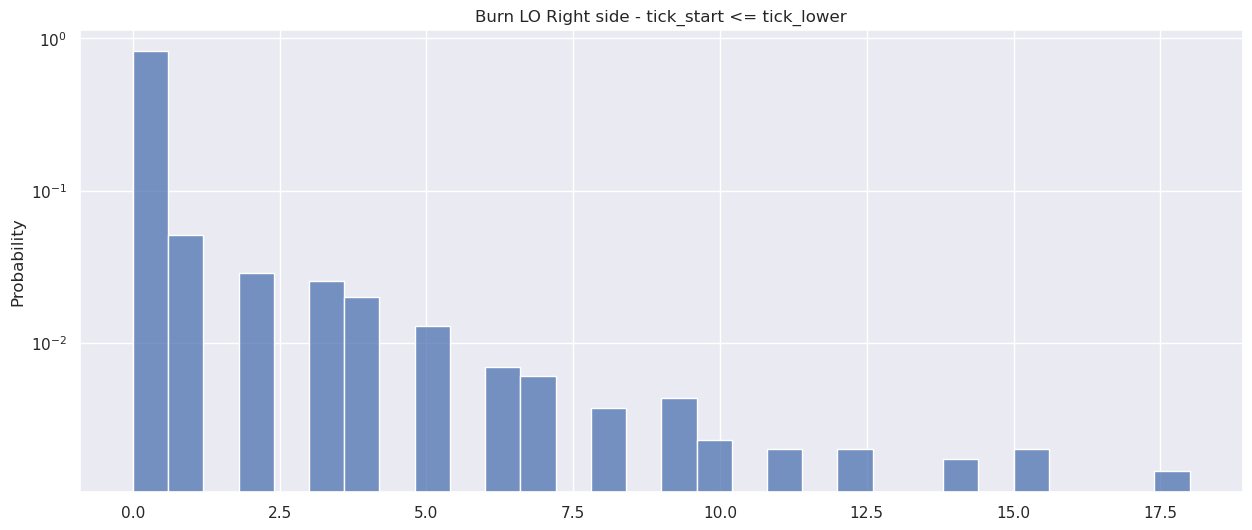

In [11]:
temp_plo = burn_lo[burn_lo.tick_start <= burn_lo.tick_lower]
x_right = np.floor((temp_plo.tick_lower - temp_plo.tick_start) / 10)

# Remove values underepresented (less than 5 occurrences)
n_del = 0
for val in x_right.unique():
    curr_len = len(x_right[x_right==val])
    if curr_len < 5:
        x_right = x_right[x_right != val]
        n_del += curr_len
print('Removed', n_del, 'obs; remaining', len(x_right), 'values')

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.set(yscale='log')
sns.histplot(x_right, stat='probability', bins=30)
plt.title('Burn LO Right side - tick_start <= tick_lower')
plt.show()

(array([ 2.68687243, -1.        ]), 3006.8452962976216)


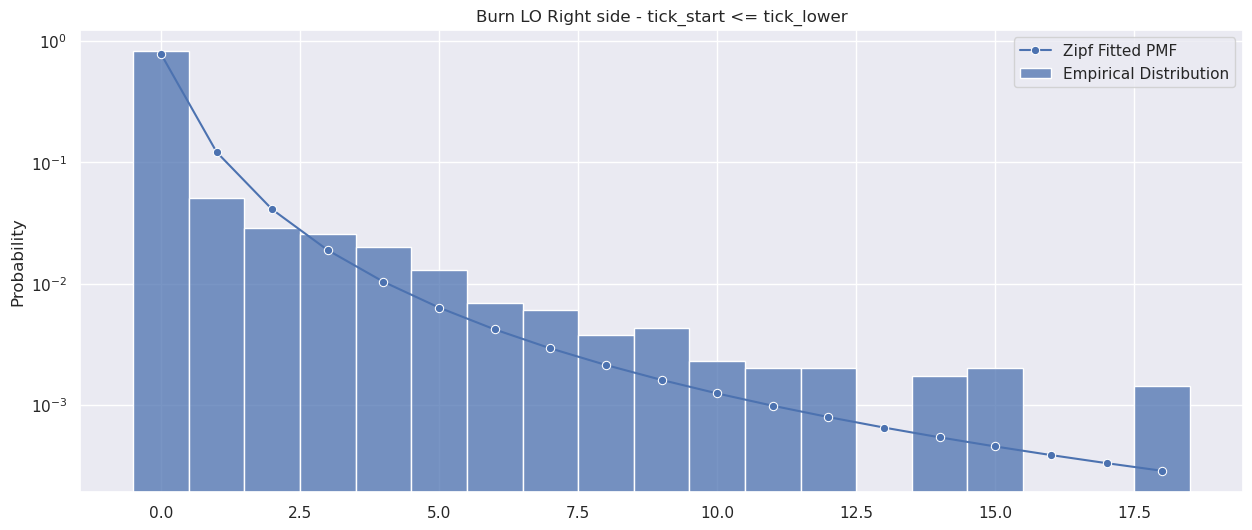

In [12]:
N = np.max(x_right) + 1
pars = discrete_fit(x_right, zipf, [1.5, -1], [(1,-1), (np.inf, -1)])
print(pars)
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.set(yscale='log')
sns.histplot(x_right, bins=np.arange(N+1)-0.5, stat='probability', kde=False, label='Empirical Distribution')
plt.title('Burn LO Right side - tick_start <= tick_lower')
x_values = np.arange(N)
fitted_pmf = zipf.pmf(x_values, *pars[0])
sns.lineplot(x=x_values, y=fitted_pmf, marker='o', label='Zipf Fitted PMF')
plt.show()

Removed 44 obs; remaining 985 values


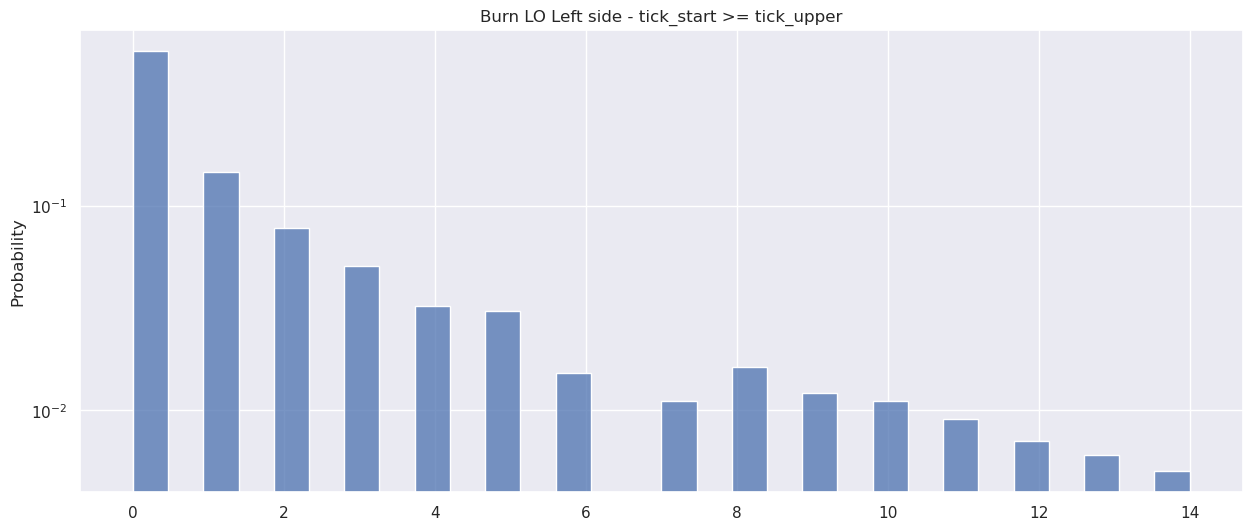

In [13]:
temp_plo = burn_lo[burn_lo.tick_start >= burn_lo.tick_upper]
x_left = np.floor((temp_plo.tick_start - temp_plo.tick_upper) / 10)

# Remove values underepresented (less than 5 occurrences)
n_del = 0
for val in x_left.unique():
    curr_len = len(x_left[x_left==val])
    if curr_len < 5:
        x_left = x_left[x_left != val]
        n_del += curr_len
print('Removed', n_del, 'obs; remaining', len(x_left), 'values')

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.set(yscale='log')
sns.histplot(x_left, stat='probability', bins=30)
plt.title('Burn LO Left side - tick_start >= tick_upper')
plt.show()

(array([ 1.9911456, -1.       ]), 1628.6043537781752)


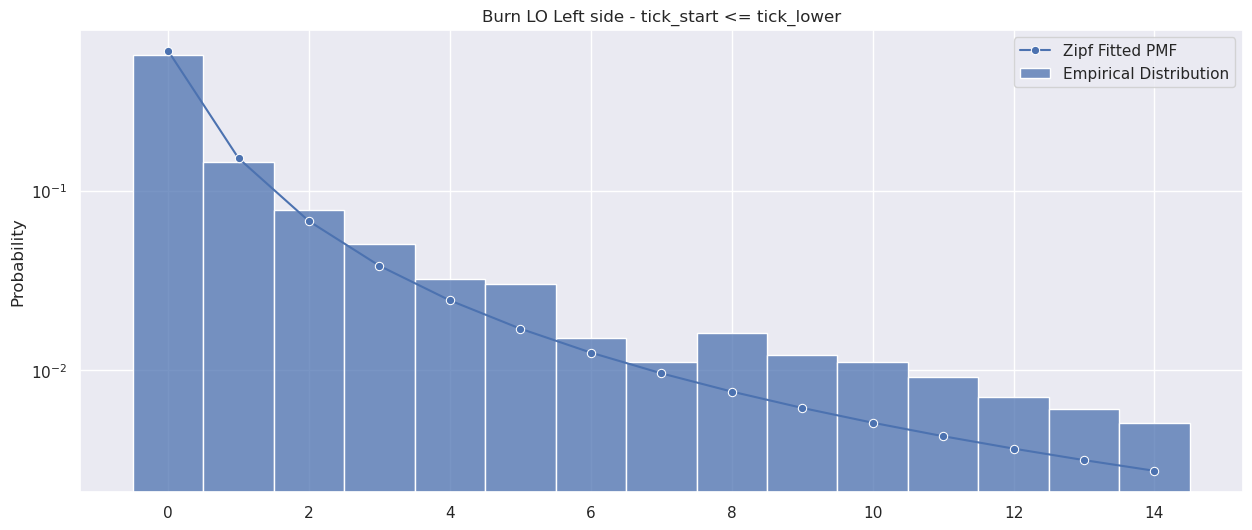

In [14]:
N = np.max(x_left) + 1
pars = discrete_fit(x_left, zipf, [1.5, -1], [(1,-1), (np.inf, -1)])
print(pars)
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.set(yscale='log')
sns.histplot(x_left, bins=np.arange(N+1)-0.5, stat='probability', kde=False, label='Empirical Distribution')
plt.title('Burn LO Left side - tick_start <= tick_lower')
x_values = np.arange(N)
fitted_pmf = zipf.pmf(x_values, *pars[0])
sns.lineplot(x=x_values, y=fitted_pmf, marker='o', label='Zipf Fitted PMF')
plt.show()

(array([ 2.68687243, -1.        ]), 3006.8452962976216)
(array([ 1.9911456, -1.       ]), 1628.6043537781752)


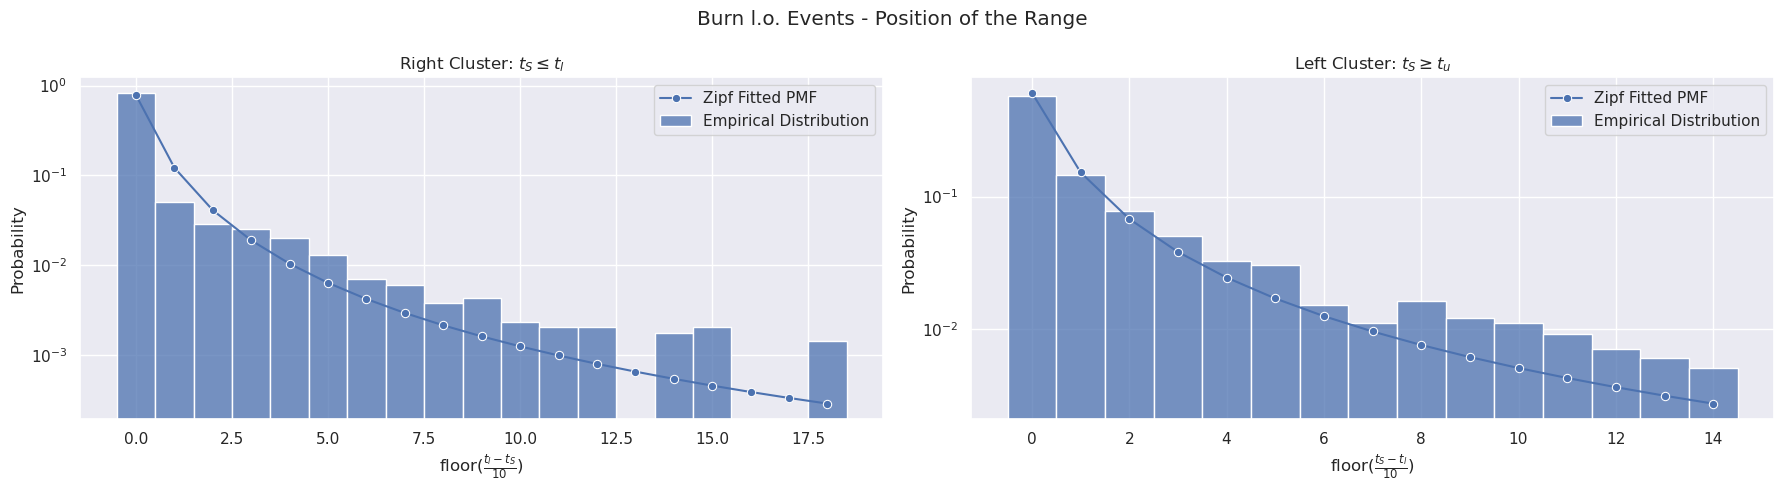

In [15]:
N = np.max(x_right) + 1
pars = discrete_fit(x_right, zipf, [1.5, -1], [(1,-1), (np.inf, -1)])
print(pars)

fig, ax = plt.subplots(1, 2, figsize=(18, 5))
ax[0].set(yscale='log')
sns.histplot(x_right, bins=np.arange(N+1)-0.5, ax=ax[0], stat='probability', kde=False, label='Empirical Distribution')
ax[0].set_title(r'Right Cluster: $t_S \leq t_l$')
x_values = np.arange(N)
fitted_pmf = zipf.pmf(x_values, *pars[0])
sns.lineplot(x=x_values, y=fitted_pmf, ax=ax[0], marker='o', label='Zipf Fitted PMF')
ax[0].set_xlabel(r'floor($\frac{t_l - t_S}{10}$)')

N = np.max(x_left) + 1
pars = discrete_fit(x_left, zipf, [1.5, -1], [(1,-1), (np.inf, -1)])
print(pars)

ax[1].set(yscale='log')
sns.histplot(x_left, bins=np.arange(N+1)-0.5, ax=ax[1], stat='probability', kde=False, label='Empirical Distribution')
plt.title(r'Left Cluster: $t_S \geq t_u$')
x_values = np.arange(N)
fitted_pmf = zipf.pmf(x_values, *pars[0])
sns.lineplot(x=x_values, y=fitted_pmf, ax=ax[1], marker='o', label='Zipf Fitted PMF')
ax[1].set_xlabel(r'floor($\frac{t_S - t_l}{10}$)')

plt.suptitle('Burn l.o. Events - Position of the Range')
plt.tight_layout()
plt.show()



In [16]:
# Direct test

from scipy.stats import chi2
from scipy.special import xlogy

def g_test_discrete(data, distribution, params):
    # Get unique values and their frequencies
    unique, counts = np.unique(data, return_counts=True)
    n = len(data)
    
    # Calculate expected frequencies
    expected = n * distribution.pmf(unique, *params)
    
    # Combine bins with expected frequency < 5
    mask = expected >= 5
    if not all(mask):
        unique = unique[mask]
        counts = counts[mask]
        expected = expected[mask]
        # Add a final bin for all remaining values
        counts = np.append(counts, n - counts.sum())
        expected = np.append(expected, n - expected.sum())
    
    # Calculate G-statistic
    g_stat = 2 * np.sum(xlogy(counts, counts / expected))
    
    # Calculate degrees of freedom
    df = len(counts) - 1 - len(params)
    
    # Calculate p-value
    p_value = 1 - chi2.cdf(g_stat, df)
    
    print("\nG-test (Likelihood Ratio Test) Results:")
    print(f"G-statistic: {g_stat}")
    print(f"p-value: {p_value}")
    
    # Interpret the results
    alpha = 0.05  # significance level
    if p_value > alpha:
        print("Fail to reject the null hypothesis. The data may follow the specified distribution.")
    else:
        print("Reject the null hypothesis. The data may not follow the specified distribution.")

In [17]:
temp_plo = burn_lo[burn_lo.tick_start <= burn_lo.tick_lower]
x_right = np.floor((temp_plo.tick_lower - temp_plo.tick_start) / 10)

pars = discrete_fit(x_right, zipf, [1.5, -1], [(1,-1), (np.inf, -1)])
g_test_discrete(x_right, zipf, pars[0])


G-test (Likelihood Ratio Test) Results:
G-statistic: 358.6638585179386
p-value: 0.0
Reject the null hypothesis. The data may not follow the specified distribution.


In [18]:
temp_plo = burn_lo[burn_lo.tick_start >= burn_lo.tick_upper]
x_left = np.floor((temp_plo.tick_start - temp_plo.tick_upper) / 10)

pars = discrete_fit(x_left, zipf, [1.5, -1], [(1,-1), (np.inf, -1)])
g_test_discrete(x_left, zipf, pars[0])


G-test (Likelihood Ratio Test) Results:
G-statistic: 19.431087821844084
p-value: 0.035116764763065356
Reject the null hypothesis. The data may not follow the specified distribution.


In [19]:
flag = np.where(burn_lo.tick_start <= burn_lo.tick_lower, 'r',
                np.where(burn_lo.tick_start >= burn_lo.tick_lower+10, 'l', 'c'))

# Unconditional probability center-left, right
print(r'Unconditional P$\left(\{flag == right\}\right) =$',  np.sum([tf in ('r') for tf in flag]) / len(flag) )
print(r'Unconditional P$\left(\{flag == center\}\right) =$',  np.sum([tf in ('c') for tf in flag]) / len(flag) )
print(r'Unconditional P$\left(\{flag == left\}\right) =$',  np.sum([tf in ('l') for tf in flag]) / len(flag) )
print()

# Conditional on right
print(r'Conditional P$\left(\{flag == right\} | \{flag_{-1} == right\}\right) =$',  np.sum([(tf in ('r')) & (tf1 in ('r')) for tf, tf1 in zip(flag[1:], flag[:-1])]) / np.sum([tf in ('r') for tf in flag[:-1]]) )
print(r'Conditional P$\left(\{flag == center\} | \{flag_{-1} == right\}\right) =$',  np.sum([(tf in ('c')) & (tf1 in ('r')) for tf, tf1 in zip(flag[1:], flag[:-1])]) / np.sum([tf in ('r') for tf in flag[:-1]]) )
print(r'Conditional P$\left(\{flag == left\} | \{flag_{-1} == right\}\right) =$',  np.sum([(tf in ('l')) & (tf1 in ('r')) for tf, tf1 in zip(flag[1:], flag[:-1])]) / np.sum([tf in ('r') for tf in flag[:-1]]) )
print()

# Conditional on center
print(r'Conditional P$\left(\{flag == right\} | \{flag_{-1} == center\}\right) =$',  np.sum([(tf in ('r')) & (tf1 in ('c')) for tf, tf1 in zip(flag[1:], flag[:-1])]) / np.sum([tf in ('c') for tf in flag[:-1]]) )
print(r'Conditional P$\left(\{flag == center\} | \{flag_{-1} == center\}\right) =$',  np.sum([(tf in ('c')) & (tf1 in ('c')) for tf, tf1 in zip(flag[1:], flag[:-1])]) / np.sum([tf in ('c') for tf in flag[:-1]]) )
print(r'Conditional P$\left(\{flag == left\} | \{flag_{-1} == center\}\right) =$',  np.sum([(tf in ('l')) & (tf1 in ('c')) for tf, tf1 in zip(flag[1:], flag[:-1])]) / np.sum([tf in ('c') for tf in flag[:-1]]) )
print()

# Conditional on left
print(r'Conditional P$\left(\{flag == right\} | \{flag_{-1} == left\}\right) =$',  np.sum([(tf in ('r')) & (tf1 in ('l')) for tf, tf1 in zip(flag[1:], flag[:-1])]) / np.sum([tf in ('l') for tf in flag[:-1]]) )
print(r'Conditional P$\left(\{flag == center\} | \{flag_{-1} == left\}\right) =$',  np.sum([(tf in ('c')) & (tf1 in ('l')) for tf, tf1 in zip(flag[1:], flag[:-1])]) / np.sum([tf in ('l') for tf in flag[:-1]]) )
print(r'Conditional P$\left(\{flag == left\} | \{flag_{-1} == left\}\right) =$',  np.sum([(tf in ('l')) & (tf1 in ('l')) for tf, tf1 in zip(flag[1:], flag[:-1])]) / np.sum([tf in ('l') for tf in flag[:-1]]) )


Unconditional P$\left(\{flag == right\}\right) =$ 0.1717334112832505
Unconditional P$\left(\{flag == center\}\right) =$ 0.7781350482315113
Unconditional P$\left(\{flag == left\}\right) =$ 0.050131540485238234

Conditional P$\left(\{flag == right\} | \{flag_{-1} == right\}\right) =$ 0.260783200908059
Conditional P$\left(\{flag == center\} | \{flag_{-1} == right\}\right) =$ 0.681044267877412
Conditional P$\left(\{flag == left\} | \{flag_{-1} == right\}\right) =$ 0.05817253121452894

Conditional P$\left(\{flag == right\} | \{flag_{-1} == center\}\right) =$ 0.14969947407963938
Conditional P$\left(\{flag == center\} | \{flag_{-1} == center\}\right) =$ 0.8063486100676184
Conditional P$\left(\{flag == left\} | \{flag_{-1} == center\}\right) =$ 0.0439519158527423

Conditional P$\left(\{flag == right\} | \{flag_{-1} == left\}\right) =$ 0.20894071914480078
Conditional P$\left(\{flag == center\} | \{flag_{-1} == left\}\right) =$ 0.6724975704567542
Conditional P$\left(\{flag == left\} | \{flag_{-1